   #               COVID-19 Literature Search Engine using LDA 

# Introduction 

1.Introduction About COVID-19

   
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.It is a family of viruses that can cause illness, which can vary from common cold and cough to sometimes more severe disease.Middle East Respiratory Syndrome (MERS-CoV) and Severe Acute Respiratory Syndrome (SARS-CoV) are such severe cases with the world has facing.SARS-CoV-2 (n-coronavirus) is the new virus of the coronavirus family, which first discovered in December 2019, which has not been identified in humans before. It is a contiguous virus which started from Wuhan in December 2019. Which later declared as Pandemic by WHO due to high rate spreads throughout the world. Currently (on date 14 April 2020), this leads to a total of 120K+ Deaths across the globe, including 83+ deaths alone in Europe.Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.Pandemic is spreading all over the world; it becomes more important to understand about this spread. 

In this notebook, the main focus is to build an index over the CORD-19 dataset to assist with analysis and data discovery. A series of tasks were explored to identify relevant articles and help find answers to key scientific questions on a number of COVID-19 research topics.please find more information here: https://www.who.int/health-topics/coronavirus#tab=tab_1


2.Research Questions


TASK1: 

What is known about transmission, incubation, and environmental stability?What is known about transmission, incubation, and environmental stability? What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control?



Specifically, we want to know what the literature reports about:


1.Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.


2.Prevalence of asymptomatic shedding and transmission (e.g., particularly children).


3.Seasonality of transmission.


4.Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).


5.Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).


6.Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).


7.Natural history of the virus and shedding of it from an infected person


8.Implementation of diagnostics and products to improve clinical processes


9.Disease models, including animal models for infection, disease and transmission


10.Tools and studies to monitor phenotypic change and potential adaptation of the virus


11.Immune response and immunity


12.Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings


13.Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and 
community settings


14.Role of the environment in transmission

# Data Preparation

Importing the Librariries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import time
import math
import random
import warnings
import json
warnings.filterwarnings("ignore")
from pathlib import Path

Loading the files:

I have downloaded datasets from the kaggle CORD-19 competition portal.
The data set I am using consist 4 folders, each folder has json files. I am using these json files as the input data to my analysis.Take a peek of the data.

In [2]:
path = 'D:\Downloads/CORD-19-research-challenge/'

In [3]:
file_names = ['biorxiv_medrxiv','comm_use_subset','custom_license','noncomm_use_subset']

Here, I am reading each pdf_json file and extracting the paper_id,metadata,title and abstract attributes.

In [4]:
paper_id=[]
title=[]
abstract=[]
for i in file_names:
    json_files= os.listdir(os.path.join(path,i,i,'pdf_json'))
    file_path=os.path.join(path,i,i,'pdf_json')
    for file_name in json_files:
        with open(file_path+'/'+file_name) as json_data:
                data = json.load(json_data)
        paper_id.append(data['paper_id'])
        title.append(data['metadata']['title'])
        da = [x['text'] for x in data['abstract']]
        da = "\n ".join(da)
        abstract.append(da)

In [5]:
sentences_df=pd.DataFrame()
sentences_df["paper"]=paper_id
sentences_df["title"]=title
sentences_df["sentence"]=abstract

In [6]:
sentences_df.columns

Index(['paper', 'title', 'sentence'], dtype='object')

In [7]:
sentences_df.shape

(36236, 3)

In [10]:
sentences_df = sentences_df.dropna()

In [11]:
print(sentences_df["sentence"][1:5])

1    During the past three months, a new coronaviru...
2                                                     
3    The fast accumulation of viral metagenomic dat...
4    Infectious bronchitis (IB) causes significant ...
Name: sentence, dtype: object


# Topic Modeling

Preprocessing Steps

Data Pre-processing:
Here I am doing performing steps:
Tokenization: It split the text into sentences and those sentences into words. Convert all the words into Lowercase and remove punctuations from the text.Removes the Words that have fewer than 3 characters. Removes the all stopwords.
Those words are lemmatized like words in third person are changed to first person and verbs in past and future tenses are changed into present.Words are reduced to their root form.

Loading gensim and nltk libraries

In [12]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
import warnings
warnings.filterwarnings("ignore")
#nltk.download('wordnet')
stemmer = PorterStemmer()

unable to import 'smart_open.gcs', disabling that module


In [13]:
document_text = sentences_df[['sentence']]
document_text['index'] = document_text.index
documents_covid = document_text
documents_covid

,sentence,index
0,word count: 194 22 Text word count: 5168 23 24...,0
1,"During the past three months, a new coronaviru...",1
2,,2
3,The fast accumulation of viral metagenomic dat...,3
4,Infectious bronchitis (IB) causes significant ...,4
...,...,...
36231,Even though coronavirus infection of humans is...,36231
36232,There is extensive evidence that cultured macr...,36232
36233,We have combined in vivo and in vitro approach...,36233
36234,We provide experimental evidence of a replicat...,36234


A function to perform lemmatize and stem processing on the text data

In [20]:
def lemmatize_stemming_covid(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess_text(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming_covid(token))
    return result

These processed data is loaded into sentence_df data frame. Later, I fed this data through a text pre-processing techniques like tokeniser, stemmer, and removal of stopwords. 

Now, I have to Preprocess the sentences, saving the results as ‘processed_docs’

In [16]:
processed_docs_covid = documents_covid['sentence'].map(preprocess_text)

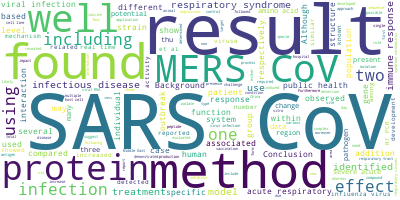

In [17]:
# Import the wordcloud library
from wordcloud import WordCloud

sentence_cloud = ','.join(list(documents_covid['sentence'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=4, contour_color='steelblue')
wordcloud.generate(sentence_cloud)
wordcloud.to_image()

From this wordcloud, I can see that most repetitive words are

# Extracting Features

Bag-of-Words:

Here I am creating a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [21]:
dictionary_covid = gensim.corpora.Dictionary(processed_docs_covid)
count = 0
for k, v in dictionary_covid.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abstract
1 acetyl
2 act
3 advantag
4 allow
5 analys
6 analysi
7 approxim
8 author
9 characteris
10 compet


Gensim filter_extremes parameters:

no_below=15 : Filter out tokens that appear in less than 15 documents (absolute number)


no_above=0.5 : more than 0.5 documents (fraction of total corpus size, not absolute number)


keep_n=100000 : keep only the first 100000 most frequent tokens.

In [22]:
dictionary_covid.filter_extremes(no_below=15, no_above=0.95, keep_n=100000)

In [23]:
bow_corpus_covid = [dictionary_covid.doc2bow(doc) for doc in processed_docs_covid]

Running LDA using Bag of Words

In [25]:
lda_model_bow = gensim.models.LdaMulticore(bow_corpus_covid, num_topics=15, id2word=dictionary_covid, passes=2, workers=2)

In [26]:
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.056*"vaccin" + 0.021*"viru" + 0.017*"antibodi" + 0.014*"immun" + 0.012*"develop" + 0.011*"infect" + 0.010*"protect" + 0.009*"antigen" + 0.009*"human" + 0.009*"respons"
Topic: 1 
Words: 0.022*"health" + 0.010*"public" + 0.009*"research" + 0.009*"develop" + 0.008*"diseas" + 0.007*"emerg" + 0.006*"need" + 0.006*"provid" + 0.005*"studi" + 0.005*"care"
Topic: 2 
Words: 0.045*"cell" + 0.025*"infect" + 0.020*"immun" + 0.018*"respons" + 0.012*"express" + 0.011*"viral" + 0.010*"viru" + 0.009*"activ" + 0.008*"induc" + 0.008*"host"
Topic: 3 
Words: 0.016*"infect" + 0.015*"mer" + 0.014*"case" + 0.014*"outbreak" + 0.011*"diseas" + 0.010*"transmiss" + 0.009*"sar" + 0.008*"studi" + 0.008*"risk" + 0.008*"control"
Topic: 4 
Words: 0.043*"patient" + 0.012*"studi" + 0.010*"clinic" + 0.010*"treatment" + 0.008*"associ" + 0.007*"hospit" + 0.007*"diseas" + 0.007*"group" + 0.007*"sever" + 0.006*"result"
Topic: 5 
Words: 0.036*"respiratori" + 0.033*"infect" + 0.017*"children" + 0.017*"viru" 

Running LDA using TF-IDF

In [27]:
from gensim import corpora, models
tfidf_covid = models.TfidfModel(bow_corpus_covid)
corpus_tfidf_covid = tfidf_covid[bow_corpus_covid]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf_covid, num_topics=15, id2word=dictionary_covid, passes=2, workers=4)

In [34]:

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.008*"pdcov" + 0.004*"ceacam" + 0.004*"infect" + 0.004*"cathepsin" + 0.004*"cell" + 0.004*"viru" + 0.004*"transfus" + 0.004*"cholesterol" + 0.003*"cyclophilin" + 0.003*"entri"
Topic: 1 Word: 0.010*"covid" + 0.006*"repositori" + 0.006*"acknowledg" + 0.006*"unrestrict" + 0.006*"grant" + 0.006*"publicli" + 0.006*"centr" + 0.006*"right" + 0.006*"fund" + 0.006*"activ"
Topic: 2 Word: 0.013*"detect" + 0.013*"assay" + 0.010*"sampl" + 0.008*"sensit" + 0.007*"test" + 0.006*"dog" + 0.006*"posit" + 0.006*"elisa" + 0.005*"canin" + 0.005*"respiratori"
Topic: 3 Word: 0.004*"sar" + 0.004*"vaccin" + 0.004*"develop" + 0.003*"proteas" + 0.003*"diseas" + 0.003*"drug" + 0.003*"sequenc" + 0.003*"viral" + 0.003*"pathogen" + 0.003*"virus"
Topic: 4 Word: 0.009*"pneumonia" + 0.009*"hajj" + 0.007*"tourism" + 0.006*"pilgrim" + 0.005*"streptococcu" + 0.005*"bacteri" + 0.004*"pneumococc" + 0.004*"tourist" + 0.003*"influenza" + 0.003*"respiratori"
Topic: 5 Word: 0.007*"patient" + 0.007*"health" + 0.0

Here, resultant data is mapped to sentence_df[‘sentences’],Prior to topic modeling, the data  convert the tokenized and lemmatised text to a bag of words and tf-idf vector.
Throughout the analysis with LDA whether it may be using BOW or TF-IDF, I have assign my own topics to assign the sentences. This is manual process,. 


In [32]:
import pickle
with open('dictionary_lda.pickle', 'wb') as handle:
    pickle.dump(dictionary_covid, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
lda_model_tfidf.save('lda_model_tfidf.model') 
lda_model_bow.save('lda_model_bow.model')

In [37]:

doc_newdata=documents_covid[1:]
doc_newdata=np.array(doc_newdata.iloc[:,0])


from gensim import corpora, models, similarities
lda_model_lda =  models.LdaModel.load('lda_model_tfidf.model')

import pickle
with open('dictionary_lda.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

In [38]:
topics=["Diagnostics","Stracture","Control-strategies","Seasonality/transmission","Children",
        "Stracture","History","Animals","Range-Incubation","Immunity-Response"
        ,"Syntoms","PPE","Tools/Studies","Animals","Immunity-Response"]

In [39]:
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import STOPWORDS

pun=[',','*','@','!','.',"'",'%','#',":","?",'>','--','↓',"(",")","<"]

p=[]
for i in range(len(doc_newdata)):
     a=(doc_newdata[i])
     word_tokens = word_tokenize(a)
     sentence = [w for w in word_tokens]
     words = [word for word in sentence if not word in pun]
     p.append(words)

In [40]:
def category(fi):
    final=fi
    su=0
    i=0
    for i in range(len(final)):
        z=final[i][1]
        su=su+z
        if su>0.9:
            break
        z=0
    k=[]
    j=0
    while j<=i:
        k.append((final[j][0],final[j][1]))
        j=j+1
 
    result=[]
    for p in range(len(k)):
        result.append((topics[k[p][0]],k[p][1]))
    return result 

In [49]:
z=[]
bow_vector = [dictionary.doc2bow(doc) for doc in p]
from gensim import corpora, models
tfidf = models.TfidfModel(bow_vector)
corpus_tfidf = tfidf[bow_vector]
for i in range(len(p)):
    fin=sorted(lda_model_lda[corpus_tfidf[i]], key=lambda tup: -1*tup[1])
    re=category(fin)
    z.append(re)

In [50]:
dat_lda=pd.DataFrame()
dat_lda['text']=doc_newdata
dat_lda['category']= z

In [51]:
dat_lda['category'].head()

0    [(Animals, 0.80171347), (Range-Incubation, 0.0...
1    [(Immunity-Response, 0.48505467), (Animals, 0....
2    [(Immunity-Response, 0.68647057), (PPE, 0.2855...
3                    [(Immunity-Response, 0.97083324)]
4    [(History, 0.37897947), (PPE, 0.21259835), (Im...
Name: category, dtype: object

In [52]:
cat=" "
from collections import defaultdict     
pp=[]
for i in range(len(dat_lda)):
    jj=dat_lda.loc[i]["category"]
    if len(jj)>1:
        def find(pairs): 
            mapp = defaultdict(list) 
            for x, y in pairs: 
                mapp[x].append(y) 
            return [(x, sum(y)) for x, y in mapp.items()] 
        k=find(jj)
        k=sorted(k, key=lambda tup: -1*tup[1])
        if len(k)>2:
            if k[0][1]+k[1][1]+k[2][1]<0.6:
                cat="General"
            else:
                if k[0][1]+k[1][1]>0.6:
                    if k[0][1]*0.4>k[1][1]:
                        cat=k[0][0]
                    elif k[0][1]>0.3:
                        if k[0][0]=="General":
                            cat="General"
                        else:
                            cat="General" +'/'+k[0][0]
                    else:
                        cat=k[0][0]+'/'+k[1][0]    
                elif k[0][1]>0.3:
                    if k[0][0]=="General":
                        cat="General"
                    else:
                        cat="General" +'/'+k[0][0]
        elif len(k)>1:
            if k[0][1]+k[1][1]>0.6:
                    if k[0][1]*0.4>k[1][1]:
                        cat=k[0][0]
                    else:
                        cat=k[0][0]+'/'+k[1][0]
            elif k[0][1]>0.3:
                
                if k[0][0]=="General":
                    cat="General"
                else:
                    cat="General" +'/'+k[0][0]
        else:
            cat=k[0][0]
            
    else:
        cat=jj[0][0]
    pp.append(cat)


dat_lda["catnew"]=pp

In [53]:
dat_lda.head()

,text,category,catnew
0,"During the past three months, a new coronaviru...","[(Animals, 0.80171347), (Range-Incubation, 0.0...",Animals
1,"Taken together, our observations suggest that ...","[(Immunity-Response, 0.48505467), (Animals, 0....",General/Immunity-Response
2,The fast accumulation of viral metagenomic dat...,"[(Immunity-Response, 0.68647057), (PPE, 0.2855...",Immunity-Response/PPE
3,"In this work, all training data are RNA virus ...","[(Immunity-Response, 0.97083324)]",Immunity-Response
4,Infectious bronchitis (IB) causes significant ...,"[(History, 0.37897947), (PPE, 0.21259835), (Im...",General/History


# Literature Search Engine Using ktrain

So, I am going with another open source package in python K-train. With the help of k-train I have archived the required results for the tasks. After applying the k-train to the huge corpus of data, finally It can answer the question related the covid from searching the pre-processed input files.

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. It is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners. With only a few lines of code, ktrain allows you to easily and quickly :
Document Recommendation Engine: given text from a sample document, recommend documents that are thematically-related to it from a larger corpus 
https://pypi.org/project/ktrain/

In [54]:
import ktrain

In [55]:
texts = sentences_df["sentence"]
model = ktrain.text.get_topic_model(texts, n_topics=None, n_features=10000,max_df=0.90)

n_topics automatically set to 139
lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [56]:
model.print_topics()
model.build(texts, threshold=0.20)

topic 0 | percolation firstly coronavirus patients incubation results preprint coronaviruses porcine size
topic 1 | ces efficiencies vigilance yield decision-making mucus belief anonymous assessment design
topic 2 | asthma airway chronic inflammation exacerbations mice exacerbation allergic inflammatory muscle
topic 3 | stewardship asp ibv contents used managing pharmacists pharmacy demands samples
topic 4 | resources market crisis cities financial preventive cooperation economy stock city
topic 5 | ecov mir-122 display reserved granted permission perpetuity preprint reuse rights
topic 6 | exact partner characterized mlv inform recommendation nucleocapsids enclosed reveals batches
topic 7 | proteins protein mammalian vlps dcs cellular functional ctl functions mammals
topic 8 | efficiency signal frameshifting elements site signals ribosomal pseudoknot frameshift downstream
topic 9 | variation transient recurrent oc43 smaller hcovs hcov-oc43 nl63 hku1 wave
topic 10 | rna gene viral genom

In [57]:
model1=ktrain.text.get_topic_model(texts, n_topics=50,n_features=10000, min_df=10, max_df=0.90)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [58]:
model1.print_topics()
model1.build(texts, threshold=0.20)

topic 0 | pedv porcine pigs prrsv tgev virus autophagy swine industry piglets
topic 1 | samples positive pcr detected results rt-pcr study tested reaction collected
topic 2 | influenza virus viruses pandemic h1n1 adenovirus h5n1 avian seasonal surveillance
topic 3 | research new development understanding future important studies recent role field
topic 4 | cases china air case countries chinese tourism reported outbreak travel
topic 5 | des resistance les antimicrobial une mucosal antibiotic antibiotics infections agents
topic 6 | antibodies antibody surface cells virus recombinant cell protein particles entry
topic 7 | cats dogs animals feline diarrhea rotavirus canine fecal intestinal lesions
topic 8 | systems capacity hong kong pressure variation region adaptive strong regions
topic 9 | study higher factors results significantly significant showed factor staff compared
topic 10 | model models data using parameters used prediction dynamics based paper
topic 11 | species human pathoge

In [59]:
model.train_recommender()

# Questions related to COVID-19(Task1)

The following are some of the results which I extracted from k-train recommender using LDA.The format for the recommender is text or query to search the whole corpus. It gives relevant topics from the corpus based on the ranking.

In [59]:
text = "about covid-19 transmission?"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	During the past three months, a new coronavirus (SARS-CoV-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. A plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate SARS-CoV-2 genetic heterogeneity and spatiotemporal dissemination. We examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. Our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. Hence the need for avoiding stigmatization based on partial information, and for continuing concerted efforts to increase number and quality of the sequences required for robust tracing of 

In [71]:
text = " Coronavirus seasonal of transmission?"
for i, doc in enumerate(tm.recommend(text=text, n=15)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split()[:500])))
    print()

RESULT #1
TEXT:
	Coronavirus disease 2019 is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), it was first identified in 2019 in Wuhan, China and has resulted in the 2019-20 coronavirus pandemic. As of March 1, 2020, 79,968 patients in China and 7169 outside of China had tested positive for COVID-19 and a mortality rate of 3.6% has been observed amongst Chinese patients. Its primary mode of transmission is via respiratory droplets from coughs and sneezes. The virus can remain viable for up to three days on plastic and stainless steel or in aerosols for upto 3 hours and is relatively more stable than the known human coronaviruses. It is stable in faeces at room temperature for at least 1-2 days and can be stable in infected patients for up to 4 days. Heat at 56°C kills the SARS coronavirus at around 10000 units per 15 minutes. Thus, temperature is an important factor in survival of COVID-19 virus and this article focuses on understanding the 

In [69]:

text = "coronavirus transmission plastic steel copper"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")


RESULT #1
TEXT:
	Coronavirus disease 2019 is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), it was first identified in 2019 in Wuhan, China and has resulted in the 2019-20 coronavirus pandemic. As of March 1, 2020, 79,968 patients in China and 7169 outside of China had tested positive for COVID-19 and a mortality rate of 3.6% has been observed amongst Chinese patients. Its primary mode of transmission is via respiratory droplets from coughs and sneezes. The virus can remain viable for up to three days on plastic and stainless steel or in aerosols for upto 3 hours and is relatively more stable than the known human coronaviruses. It is stable in faeces at room temperature for at least 1-2 days and can be stable in infected patients for up to 4 days. Heat at 56°C kills the SARS coronavirus at around 10000 units per 15 minutes. Thus, temperature is an important factor in survival of COVID-19 virus and this article focuses on understanding the 

In [70]:
text = "coronavirus incubation period?"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	medRxiv preprint 3 generally longer incubation and serial interval of less severe cases suggests a high risk of longterm epidemic in the absence of appropriate control measures.

RESULT #2
TEXT:
	Seasonal variation in COVID-19 incidence could impact the trajectory of the pandemic. Using global linelist data on COVID-19 cases reported until 29 th February 2020 and global gridded temperature data, and after adjusting for surveillance capacity and time since first imported case, higher average temperature was strongly associated with lower COVID-19 incidence for temperatures of 1°C and higher. However, temperature explained a relatively modest amount of the total variation in COVID-19 incidence. These preliminary findings support stringent containment efforts in Europe and elsewhere.

RESULT #3
TEXT:
	We plotted daily data on the frequencies of keywords related to severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) from WeChat, a Chinese social media. Using "Feid

In [60]:
text = "What is known about covid-19 incubation period?"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	Based on publicly released data for 1212 patients, we investigated the epidemiological characteristics of COVID-19 in Henan of China. The following findings are obtained: 1) COVID-19 patients in Henan show gender (55% vs 45%) and age (81% aged between 21 and 60) preferences, possible causes were explored; 2) Statistical analysis on 483 patients reveals that the estimated average, mode and median incubation periods are 7.4, 4 and 7 days; Incubation periods of 92% patients were no more than 14 days; 3) The epidemic of COVID-19 in Henan has undergone three stages and showed high correlations with the numbers of patients that recently return from Wuhan; 4) Network analysis on the aggregate outbreak phenomena of COVID-19 revealed that 208 cases were clustering infected, and various people's Hospital are the main force in treating patients. The related investigations have potential implications for the prevention and control of COVID-19.

RESULT #2
TEXT:
	Through collection 

In [62]:

text = "how long individuals are contagious, even after recovery.?"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	Background: The novel coronavirus (SARS-CoV-2) pandemic is driving many countries to adopt global isolation measures in an attempt to slow-down its spread. These extreme measures are associated with extraordinary economic costs. Objective: To compare the cost-effectiveness of global isolation of the whole population to focused isolation of individuals at high risk of being exposed, augmented by thorough PCR testing. Design: We applied a modified Susceptible, Exposed, Infectious, Removed (SEIR) model to compare two different strategies in controlling the SARS-CoV-2 spread. Data sources and target population: We modeled the dynamics in Israel, a small country with ~ 9 million people. Interventions: 1. Global isolation of the whole population (strategy 1) 2. Focused isolation of people at high risk of exposure with extensive PCR testing (strategy 2). Outcome measures: Number of deaths and the cost per one avoided death in strategy 1 vs 2. The number of expected deaths is 

In [75]:
text = "nasal discharge coronavirus,covid-19 Persistence and stability?"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	COVID-19 (SARS-CoV-2

RESULT #2
TEXT:
	Cases from the ongoing outbreak of atypical pneumonia caused by the 2019 novel coronavirus (2019-nCoV) exported from mainland China can lead to self-sustained outbreaks in other populations.

RESULT #3
TEXT:
	The ongoing outbreak of coronavirus disease 2019 (COVID-19) caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) started in the end of 2019 in China has triggered a global public health crisis. Previous studies have shown that SARS-CoV-2 infects cells by binding angiotensin-converting enzyme 2 (ACE2), which is the same as SARS-CoV. The expression and distribution of ACE2 in the pancreas are unknown. At the same time, the injury of pancreas after SARS-CoV-2 infection has not been concerned. Here, we collected public datasets (bulk RNA-seq and single-cell RNA-seq) to indicate the expression and the distribution of ACE2 in pancreas (in both exocrine glands and islets). And further, clinical data including mild 

In [77]:
text = "immunity against coronavirus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	The beginning of 2020 has seen the emergence of COVID-19 outbreak caused by a novel coronavirus, Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2). There is an imminent need to better understand this new virus and to develop ways to control its spread. In this study, we sought to gain insights for vaccine design against SARS-CoV-2 by considering the high genetic similarity between SARS-CoV-2 and SARS-CoV, which caused the outbreak in 2003, and leveraging existing immunological studies of SARS-CoV. By screening the experimentally-determined SARS-CoV-derived B cell and T cell epitopes in the immunogenic structural proteins of SARS-CoV, we identified a set of B cell and T cell epitopes derived from the spike (S) and nucleocapsid (N) proteins that map identically to SARS-CoV-2 proteins. As no mutation has been observed in these identified epitopes among the available SARS-CoV-2 sequences (as of 9 February 2020), immune targeting of these epitopes may potentially

In [80]:
text="coronaviruses Disease models, including animal models for infection, disease and transmission"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	On December 31, 2019, the World Health Organization was notified about a cluster of pneumonia of unknown aetiology in the city of Wuhan, China. Chinese authorities later identified a new coronavirus (2019-nCoV) as the causative agent of the outbreak. As of January 23, 2020, 655 cases have been confirmed in China and several other countries. Understanding the transmission characteristics and the potential for sustained human-to-human transmission of 2019-nCoV is critically important for coordinating current screening and containment strategies, and determining whether the outbreak constitutes a public health emergency of international concern (PHEIC). We performed stochastic simulations of early outbreak trajectories that are consistent with the epidemiological findings to date. We found the basic reproduction number, R 0 , to be around 2.2 (90% high density interval 1.4-3.8), indicating the potential for sustained human-to-human transmission. Transmission characteristi

In [81]:
text="phenotypic change and potential adaptation of the coronaviruses"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	The beginning of 2020 brought us information about the novel coronavirus emerging in China. 39 Rapid research resulted in the characterization of the pathogen, which appeared to be a member 40 of the SARS-like cluster, commonly seen in bats. Despite the global and local efforts, the virus 41 escaped the healthcare measures and rapidly spread in China and later globally, officially 42 causing a pandemic and global crisis in March 2020. At present, different scenarios are being 43 written to contain the virus, but the development of novel anticoronavirals for all highly 44 pathogenic coronaviruses remains the major challenge. Here, we describe the antiviral activity 45 of previously developed by us HTCC compound (N-(2-hydroxypropyl)-3-trimethylammonium 46 chitosan chloride), which may be used as potential inhibitor of currently circulating highly 47 pathogenic coronaviruses -SARS-CoV-2 and MERS-CoV. : bioRxiv preprint 65 pneumocytes in human airways, hijacking the angiot

In [84]:
text=" secondary transmission corona"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	The exact source of infection remains difficult to identify. Case 1 could have been infected during his visit to a Page 4 of 6 http://www.ete-online.com/content/11/1/16 hospital and subsequently have infected Case 2. However, exposure to a common source for both Case 1 and 2 cannot be ruled out. Besides, Case 1 may have been exposed to a yet unidentified source and subsequently have infected Case 2, or vice versa. More research to relevant sources in the Arabian Peninsula is needed. The suggested role of underlying disease to develop MERS-CoV infection is in line with the age and comorbidity of the two Dutch cases and the absence of symptomatic MERS-CoV infections among the younger and healthier travellers.

RESULT #2
TEXT:
	Knowledge of human behaviors is important for improving indoor-environment design, building-energy efficiency, and productivity, and for studies of infection spread. However, such data are lacking. In this study, we designed a device for detecting 

In [61]:
text = " about covid-19 environmental stability?"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	During the past three months, a new coronavirus (SARS-CoV-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. A plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate SARS-CoV-2 genetic heterogeneity and spatiotemporal dissemination. We examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. Our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. Hence the need for avoiding stigmatization based on partial information, and for continuing concerted efforts to increase number and quality of the sequences required for robust tracing of 

In [85]:
text="Effectiveness of personal protective equipment (PPE)"
for i, doc in enumerate(tm.recommend(text=text, n=10)):
    print('RESULT #%s'% (i+1))
    print('TEXT:\n\t%s' % (doc[0]))
    print()

RESULT #1
TEXT:
	In the face of the catastrophic health emergency caused by COVID-19, medical staff have been affected by different kinds of subjective and objective factors. Their mental health problems are a form of human stress response, an explanatory, emotional, and defensive response within the human body, and a physiological response of the human body to the invasion of needs or injuries. In this special environment, their work, life, and emotions tend to be regularly abnormal. Due to the requirements for isolation and disinfection, medical personnel need to wear several layers of protection clothing. This increases the intensity of their work and requires great physical energy, causing severe hypoxia and physical symptoms such as headache and muscle soreness. Other symptoms such as obsessive-compulsive symptoms, interpersonal sensitivity, depression, anxiety, phobic anxiety, hostility, and paranoid ideation are all normal psychological reactions in the handling of emergencies a

In [88]:
text="Natural history of the corona virus"
for i, doc in enumerate(tm.recommend(text=text, n=10)):
    print('RESULT #%s'% (i+1))
    print('TEXT:\n\t%s' % (doc[0]))
    print()

RESULT #1
TEXT:
	Influenza epidemiological and virologic data from Georgia are limited. We aimed to present Influenza Like Illness (ILI) and Severe Acute Respiratory Infection (SARI) surveillance data and characterize influenza viruses circulating in the country over three influenza seasons. We analyzed sentinel site ILI and SARI data for the 2014-2017 seasons in Georgia. Patients' samples were screened by real-time RT-PCR and influenza viruses isolated were characterized antigenically by haemagglutination inhibition assay and genetically by sequencing of HA and NA genes.

RESULT #2
TEXT:
	Based on a unique longitudinal sampling of multiple body habitats and a comparative approach on two bat species, we investigated the within-colony dynamics of both microbiota and viral/bacterial shedding during the seasonal reproduction of bats. Our results demonstrated that seasonal reproduction is characterized by substantial changes of the microbiota and shedding patterns, which are mainly driven 

In [89]:
text="Natural history of the coronaviruses"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	There is concern about a new coronavirus, the 2019-nCoV, as a global public health threat. In this article, we provide a preliminary evolutionary and molecular epidemiological analysis of this new virus. A phylogenetic tree has been built using the 15 available whole genome sequence of 2019-nCoV and 12 whole genome sequences highly similar sequences available in gene bank (5 from SARS, 2 from MERS and 5 from Bat SARS-like Coronavirus). FUBAR analysis shows that the Nucleocapsid and the Spike Glycoprotein has some sites under positive pressure while homology modelling helped to explain some molecular and structural differences between the viruses. The phylogenetic tree showed that 2019.nCoV significantly clustered with Bat SARS-like Coronavirus sequence isolated in 2015, whereas structural analysis revealed mutation in S and nucleocapsid proteins. From these results, 2019nCoV could be considered a coronavirus distinct from SARS virus, probably transmitted from bats or a

In [90]:
text="Role of the environment in transmission of conoravirus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	Background: As of March 2, 2020, SARS-CoV-2 has infected more than 80174 people and caused 2915 deaths in China. This virus rapidly spreads to 56 countries worldwide. Thus, in order to effectively block its transmission, it is urgent to uncover all the possible transmission routes of SARS-CoV-2. Methods: From January 28 to February 18, 2020, 35 female patients diagnosed with COVID-19 in Tongji Hospital were included in this descriptive study. The gynecologic history, clinical characteristics, laboratory findings and chest computed tomography (CT) of all patients were recorded in detail. To examine whether there is sexual transmission through vaginal from female to her partner, we employed realtime polymerase chain reaction testing (RT-PCR) to detect SARS-CoV-2 in vaginal environment (including vaginal discharge, cervical or vaginal residual exfoliated cells) and anal swab samples, and inquired recent sexual behaviors from the patients. Findings: The age range of the 35

In [91]:
text="Physical science of the coronavirus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	Background: Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is a virus that causes severe respiratory illness in humans, which eventually results in the current outbreak of novel coronavirus disease around the world. The research community is interested to know what are the hotspots in coronavirus (CoV) research and how much is known about COVID-19. This study aimed to evaluate the characteristics of publications involving coronaviruses as well as COVID-19 by using a topic modeling analysis. : We extracted all abstracts and retained the most informative words from the COVID-19 Open Research Dataset, which contains all the 35,092 pieces of coronavirus related literature published up to March 20, 2020. Using Latent Dirichlet Allocation modeling, we trained an eighttopic model from the corpus. We then analyzed the semantic relationships between topics and compared the topic distribution between COVID-19 and other CoV infections. Results: Eight topics emerged 

In [97]:
text="Implementation of diagnostics of corona virus and clinical processes"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

RESULT #1
TEXT:
	Objective: To investigate the correlation between clinical characteristics and cardiac injury of COVID-2019 pneumonia.

RESULT #2
TEXT:
	Currently, there are no approved specific antiviral agents for 2019 novel coronavirus disease . In this study, ten severe patients confirmed by real-time viral RNA test were enrolled prospectively. One dose of 200 mL convalescent plasma (CP) derived from recently recovered donors with the neutralizing antibody titers above 1:640 was transfused to the patients as an addition to maximal supportive care and antiviral agents. The primary endpoint was the safety of CP transfusion. The second endpoints were the improvement of clinical symptoms and laboratory parameters within 3 days after CP transfusion. The median time from onset of illness to CP transfusion was 16.5 days. After CP transfusion, the level of neutralizing antibody increased rapidly up to 1:640 in five cases, while that of the other four cases maintained at a high level (1:64

In [60]:
text = "Range of incubation periods for the CIVID-19 disease in humans "
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Through collection of publicly released patients information by various CDCs in Henan province during January 21 to February 14 of 2020, we performed statistical analysis on 1212 confirmed patients infected with COVID-19. The number of newly confirmed cases reached its peak at February 3, and it started . CC-BY-NC-ND 4.0 International license It is made available under a author/funder, who has granted medRxiv a license to display the preprint in perpetuity. is the (which was not peer-reviewed) The copyright holder for this preprint . https://doi.org/10.1101/2020.02. 21.20026112 doi: medRxiv preprint to fall after that day. Among the 18 regions of Henan, Xinyang is with the heaviest epidemic, and it is currently also with the highest daily increment. We found that 55% patients in Henan were male, which is apparently higher than the females. We found that the gender difference of patients in Henan is 1.2226 : 1, while from Yang et al. [4] , they reported that the gender difference

In [61]:
text = "how coronavirus varies across age and health status "
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	BACKGROUND Person to person spread of COIVD-19 in the UK has now been confirmed. There are limited case series reporting the impact on women affected by coronaviruses (CoV) during pregnancy. In women affected by SARS and MERS, the case fatality rate appeared higher in women affected in pregnancy compared with non-pregnant women. We conducted a rapid, review to guide management of women affected by COVID -19 during pregnancy and developed interim practice guidance with the RCOG and RCPCH to inform maternity and neonatal service planning METHODS Searches were conducted in PubMed and MedRxiv to identify primary case reports, case series, observational studies or randomised-controlled trial describing women affected by coronavirus in pregnancy and on neonates. Data was extracted from relevant papers and the review was drafted with representatives of the RCPCH and RCOG who also provided expert consensus on areas where data were lacking RESULTS From 9964 results on PubMed and 600 on M

In [62]:
text = "how long individuals are contagious, even after recovery from COVID-19."
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Background: The novel coronavirus (SARS-CoV-2) pandemic is driving many countries to adopt global isolation measures in an attempt to slow-down its spread. These extreme measures are associated with extraordinary economic costs. Objective: To compare the cost-effectiveness of global isolation of the whole population to focused isolation of individuals at high risk of being exposed, augmented by thorough PCR testing. Design: We applied a modified Susceptible, Exposed, Infectious, Removed (SEIR) model to compare two different strategies in controlling the SARS-CoV-2 spread. Data sources and target population: We modeled the dynamics in Israel, a small country with ~ 9 million people. Interventions: 1. Global isolation of the whole population (strategy 1) 2. Focused isolation of people at high risk of exposure with extensive PCR testing (strategy 2). Outcome measures: Number of deaths and the cost per one avoided death in strategy 1 vs 2. The number of expected deaths is 389 in str

In [63]:
text = "Prevalence of asymptomatic shedding and transmission particularly children with respect to corona virus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Background: Acute respiratory illnesses (ARIs) during childhood are often caused by respiratory viruses, result in significant morbidity, and have associated costs for families and society. Despite their ubiquity, there is a lack of interdisciplinary epidemiologic and economic research that has collected primary impact data, particularly associated with indirect costs, from families during ARIs in children. We conducted a 12-month cohort study in 234 preschool children with impact diary recording and PCR testing of nose-throat swabs for viruses during an ARI. We used applied values to estimate a virus-specific mean cost of ARIs. Results: Impact diaries were available for 72% (523/725) of community-managed illnesses between January 2003 and January 2004. The mean cost of ARIs was AU$309 (95% confidence interval $263 to $354). Influenza illnesses had a mean cost of $904, compared with RSV, $304, the next most expensive single-virus illness, although confidence intervals overlapped

In [64]:
text = "Seasonality transmission of corona virus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	300 words) 33 Quantification of aerosolized influenza virus is used for determining inhalation exposure. Several 34 bioaerosol samplers and analytical methods have been used; however, the detection and 35 quantification of influenza virus among aerosol samples remains challenging. Therefore, 36 improved viral aerosol measurement methods are needed. This study evaluated influenza virus 37 recovery among three filter types polytetrafluoroethylene, polyvinylchloride and polystyrene. 38 Polytetrafluoroethylene, polyvinylchloride are fabricated filter materials and commonly used in 39 the scientific literature to sample for viral aerosols. A novel, electrospun polystyrene filter 40 material may improve viral aerosol recovery during filter-based air sampling. The filter materials 41 were compared across the following conditions: treated with or without air, filter wash buffer 42 (HBSS or PBS), and viral RNA extraction method (QIAamp Viral RNA Mini Kit or Trizol). 43 Twenty trials were

In [65]:
text = "Physical science of the coronavirus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Background: Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is a virus that causes severe respiratory illness in humans, which eventually results in the current outbreak of novel coronavirus disease around the world. The research community is interested to know what are the hotspots in coronavirus (CoV) research and how much is known about COVID-19. This study aimed to evaluate the characteristics of publications involving coronaviruses as well as COVID-19 by using a topic modeling analysis. : We extracted all abstracts and retained the most informative words from the COVID-19 Open Research Dataset, which contains all the 35,092 pieces of coronavirus related literature published up to March 20, 2020. Using Latent Dirichlet Allocation modeling, we trained an eighttopic model from the corpus. We then analyzed the semantic relationships between topics and compared the topic distribution between COVID-19 and other CoV infections. Results: Eight topics emerged overall: c

In [66]:
text = "Persistence and stability on a multitude of substrates and sources for coronavirus (e.g., nasal discharge, sputum, urine, fecal matter, blood)"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	The results of the present study found signifi cant decreases of procalcitonin, presepsin and IL-6 resulting from 3 days of immunoglobulin administration, but evidence is still limited and this needs to be confi rmed in larger studies. Introduction Presepsin (sCD14-ST) serves as a mediator of the response to infectious agents. First evidence suggested that presepsin may be utilized as a sepsis marker. Methods Presepsin was determined at presentation (T0), after 8, 24 and 72 hours in 123 individuals admitted with signs of SIRS and/ or infection. Primary endpoint was death within 30 days. Presepsin was determined using the POC assay PATHFAST Presepsin (Mitsubishi Chemical, Japan). Results Mean presepsin concentrations of the patient group at presentation and of the control group were 1,945 and 130 pg/ml, respectively (P <0.0001). Baseline presepsin diff ered highly signifi cant between patients with SIRS, sepsis, severe sepsis and septic shock. Twenty-four patients died during 30 

In [67]:
text="Implementation of CIVID-19 diagnostics and products to improve clinical processes"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Lung ultrasound can play a major and valuable role in the diagnosis of pneumonia with high diagnostic accuracy. Moreover, it can be an alternative to chest X-ray and thoracic CT in several conditions. LUS can be used at the bedside easily, safely, and repetitively. Using LUS in Emergency department, ICUs, and medical wards after adequate training can be considered as a disruptive technology in this field.


TEXT:
	In the pediatric population, respiratory infections are the most common cause of physician visits. Although many respiratory illnesses are self-limiting viral infections that resolve with time and supportive care, it can be critical to identify the causative pathogen at an early stage of the disease in order to implement effective antimicrobial therapy and infection control. Over the last few years, diagnostics for respiratory infections have evolved substantially, with the development of novel assays and the availability of updated tests for newer strains of pathogens

In [68]:
text="COVID-19 Disease models, including animal models for infection, disease and transmission"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	The ecological success of social insects is based on division of labour, not only between queens 20 and workers, but also among workers. Whether a worker tends the brood or forages is strongly 21 influenced by age, fertility and nutritional status, with brood carers being younger, more fecund 22 and corpulent. Here, we experimentally disentangle behaviour from age and fertility 23 in Temnothorax longispinosus ant workers and analyse how these parameters are linked to 24 whole-body gene expression. Our transcriptome analysis reveals four times more genes 25 associated with behaviour than with age and only few fertility-associated genes. Brood carers 26 exhibited an upregulation of genes involved in lipid biosynthesis, whereas foragers invested in 27 metabolism. Additional simulations revealed that the experimental disassociation of co-varying 28 factors reduces transcriptomic noise, potentially explaining discrepancies between 29 transcriptomic studies on worker behaviour in othe

In [69]:
text="Tools and studies to monitor phenotypic change and potential adaptation of the coronavirus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Recombination is a process that unlinks neighbouring loci allowing for independent evolutionary trajectories within genomes of many organisms. If not properly accounted for, recombination can compromise many evolutionary analyses. In addition, when dealing with organisms that are not obligately sexually reproducing, recombination gives insight into the rate at which distinct genetic lineages come into contact. Since June, 2012, Middle East respiratory syndrome coronavirus (MERS-CoV) has caused 1106 laboratory-confirmed infections, with 421 MERS-CoV associated deaths as of April 16, 2015. Although bats are considered as the likely ultimate source of zoonotic betacoronaviruses, dromedary camels have been consistently implicated as the source of current human infections in the Middle East. In this paper we use phylogenetic methods and simulations to show that MERS-CoV genome has likely undergone numerous recombinations recently. Recombination in MERS-CoV implies frequent co-infecti

In [70]:
text="Immune response and immunity to coronavirus"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	The overall picture that emerges is that mallard ducks are very permissive to LPAI replication in their intestines without cost to fitness, and have robust immune responses that give ducks some ability to cope with the spontaneous tendency of LPAI viruses to periodically acquire high pathogenicity and broad tissue tropism. Mallard ducks are not universally resistant to disease caused by all strains of HPAIV, but are much more resistant than chickens, which lack the RIG-I receptor, and relatively more resistant than other bird species. Tight control of pro-inflammatory signaling contributes to the survival of mallards, and may be helped by a lack of viral endothelial tissue tropism and the ducks' ability to tolerate some extent of central nervous system infection. RIG-I receptor-mediated IFN-β signaling in infected cells and the rapid induction of ISGs is critical to limiting HPAI virus spread and viremia early, and to limiting inflammation. The potential strain-dependent role of

In [71]:
text="Effectiveness of movement control strategies to prevent secondary transmission of  virus in health care and community settings"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	Background The outbreak of COVID-2019 is becoming a global public health


TEXT:
	We affirm that the concept of global justice for all persons needs to be applied to the shortage of pediatric and adult critical care services across the globe. At the core, there is a need to remediate inequalities of access to healthcare as a fundamental human right (133) . The injustice of the disparity in healthcare requires tireless patient advocacy for equity of care and increased resources (73) . We no longer live in silos; instead, we live in an interconnected world where communications, collaboration, trade, finance, and pollution are all shared (84) . The recent Ebola epidemic served as a harsh reminder that in order to value all human life equally, there is an urgent need to bridge resource-rich and resourcelimited worlds and build effective, long-lasting partnerships across borders (83) . Critical care has often been deemed inappropriate and of lower priority than primary care efforts a

In [72]:
text="Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of virus transmission in health care and community settings"
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	The legal behaviors in using medical masks in public have been finally promulgated by the Vietnamese Government after 47 days since the WHO declared the Public Health Emergency of International Concern (PHEIC) due to the COVID-19 pandemic. From a sample of 345 Vietnamese respondents aged from 15 to 47 years, this brief note found that the risk perception of COVID-19 danger significantly increases the likelihood of wearing the medical masks. In addition, there is a weak evidence about the differences in age under the COVID-19 outbreaks. More noticeably, those who use masks before COVID-19 pandemic tend to maintain their behaviors. Our results offer the insightful into Vietnamese citizens' responses in terms of using medical masks; even the uses of this method are still controversial. Our results are robust by performing Exploratory Factor Analysis for five features and further regressions.


TEXT:
	Objective: Health system resilience and resilience of a country include the capaci

In [73]:
text="Effectiveness of drugs being developed and tried to treat COVID-19 patients."
for i, doc in enumerate(model.recommend(text=text, n=10)):
    print('TEXT:\n\t%s' % (" ".join(doc[0].split())))
    print("\n")

TEXT:
	2019-nCov has caused more than 80 deaths as of 27 January 2020 in China, and infection cases have been reported in more than 10 countries. However, there is no approved drug to treat the disease. 2019-nCov M pro is a potential drug target to combat the virus. We built homology models based on SARS M pro structures, and docked 1903 small molecule drugs to the models. Based on the docking score and the 3D similarity of the binding mode to the known M pro ligands, 4 drugs were selected for binding free energy calculations. Both MM/GBSA and SIE methods voted for nelfinavir, with the binding free energy of -24.69±0.52 kcal/mol and -9.42±0.04 kcal/mol, respectively. Therefore, we suggested that nelfinavir might be a potential inhibitor against 2019-nCov M pro . author/funder. All rights reserved. No reuse allowed without permission.


TEXT:
	The World Health Organization (WHO) has declared the 2019 novel coronavirus (2019-nCoV) infection outbreak a global health emergency. Currently, 

References


[1]	Gurusamy, Vairaprakash & Kannan, Subbu. (2014). Preprocessing Techniques for Text Mining.,2014

[2]	Tong, Zhou & Zhang, Haiyi. (2016). A Text Mining Research Based on LDA Topic Modelling. Computer Science & Information Technology. 6. 201-210. 10.5121/csit.2016.60616

[3]	Sanchit,Tiwari. (2020) Citation: COVID-19 Research Data Analysis and Insights. Medium., Retrieved from https://medium.com/@sanchit.srijit/covid-19-research-data-analysis-and-insights-1d9b40386911

[4]	Maiya,Arun S(2004).,ktrain: A Low-Code Library for Augmented Machine Learning,	arXiv:2004.10703 [cs.LG]

[5]	Citation: Latent Dirichlet allocation(2017). Wikipedia, the free encyclopedia,. Retrieved from https://en.wikipedia.org/wiki/Latent_Dirichlet

[6]	Priya,Dwivedi. (2018) Citation: NLP: Extracting the main topics from your dataset using LDA in minutes. Medium., Retrieved from https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925

[7]	Arun,Maiya. (2019) Citation: ktrain: A Lightweight Wrapper for Keras to Help Train Neural Networks. Medium., Retrieved from https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c

[8]	Arun,Maiya. (2019) Citation: ktrain 0.14.4. github., Retrieved from https://pypi.org/project/ktrain/

[9]	Citation: Bag-of-words model. Wikipedia, the free encyclopedia,. Retrieved from https://en.wikipedia.org/wiki/Bag-of-words_model

[10]	Tarun,Paparaju. (2020) Citation: COVID-19 Dataset : Gaining actionable insights. Kaggle., Retrieved from https://www.kaggle.com/tarunpaparaju/covid-19-dataset-gaining-actionable-insights

[11]	Hazom. (2020) Citation: COVID-19 Search Engine - Task 1. Kaggle., Retrieved from https://medium.com/@sanchit.srijit/covid-19-research-data-analysis-and-insights-1d9b40386911
